### Домашнее задание (Ансамблирование)

Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)

1. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей

2. Построить случайный лес, вывести важность признаков

3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

4. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии

5. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)

6. В качестве решения: Jupyter notebook с кодом, комментариями и графиками, ссылка на гитхаб

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split


%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
jtplot.style(figsize=(10.0, 8.0))

#### 0.0 Загрузка данных и препроцессинг данных

алгоритм:
1. загружаем данные (train и test)
2. обьединяем train и test
3. заполняем пропущенные значения (для категориальных nan, количественных mean/median)
4. one hot encoding
5. разделим наш df на train и test

- Загружаем данные

In [2]:
#загружаем данные 
train = pd.read_csv('all-2/train.csv')
test = pd.read_csv('all-2/test.csv')

In [3]:
train.shape

(1460, 81)

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.shape

(1459, 80)

In [6]:
#выполним нормализацию и сохраним таргет в y_train, ну и дропним таргет из train
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train.SalePrice
train.drop('SalePrice', axis=1, inplace=True)

In [7]:
#проверим что признаки в train и test совпадают
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

- Обьединяем train и test

In [8]:
#перед обьединением наборов данных добавим разметку 
train['is_test'] = 0
test['is_test'] = 1

In [9]:
#обьединяем
df = pd.concat([train, test])

- Заполняем пропуски (стратегия: для количественных берем медианное значение, для порядковых наиболее часто встречающиеся) 

In [10]:
#сначала дропним признаки которые не корректно заполнять с помощью выбранной стратегии

df.drop(['PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'Alley'], axis=1, inplace=True)

In [11]:
#заполним пропущенные категориальные признаки
cat_feat = list(df.dtypes[df.dtypes == object].index)

for x in cat_feat:
    df[x] = df[x].fillna(max(dict(df[x].value_counts())))

In [12]:
#заполним пропущенные количественные признаки
count_feat = list(df.dtypes[df.dtypes != object].index)

for x in count_feat:
    df[x] = df[x].fillna(df[x].median())

In [13]:
#проверим
min(df.count()) == max(df.count())

True

In [14]:
df.shape

(2919, 76)

- one hot encoding

In [15]:
#выполним one hot encoding
df_dummy = pd.get_dummies(df, columns=cat_feat)

In [16]:
df_dummy.shape

(2919, 272)

In [17]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 272 entries, Id to SaleCondition_Partial
dtypes: float64(11), int64(27), uint8(234)
memory usage: 1.5 MB


In [18]:
df_dummy['is_test'].count()

2919

In [19]:
X_train = df_dummy[df_dummy.is_test==0].drop('is_test', axis=1)
X_test = df_dummy[df_dummy.is_test==1].drop('is_test', axis=1)

In [20]:
#проверим вертикально
(len(X_train) == len(train)) and (len(X_test) == len(test))

True

In [21]:
#проверим горизонтально
len(X_train.columns) == len(X_test.columns)

True

#### 0.1 Выполним нормализацию наших данных

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scaler_train = StandardScaler()
scaler_test = StandardScaler()

In [24]:
columns_train = X_train.columns
columns_test = X_test.columns

In [25]:
scaler_train.fit(X_train)
scaler_test.fit(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [26]:
X_train_scaled = scaler_train.transform(X_train)
X_train_scaled_f = pd.DataFrame(X_train_scaled, columns=columns_train)

In [27]:
X_test_scaled = scaler_test.transform(X_test)
X_test_scaled_f = pd.DataFrame(X_test_scaled, columns=columns_test)

#### 0.2 Тестим данные на простой регрессии / 1.  10-fold кросс-валидацию для оценки качества модели LinearRegression
Построить линейную регрессию и посмотрим на важность признаков

In [28]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled_f, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
price_predictions = lin_reg.predict(X_train_scaled_f)
lin_mse = mean_squared_error(y_train, price_predictions)
lin_rmse = np.sqrt(lin_mse)

print('RMSE на train: {:.4f}'.format(lin_rmse))

RMSE на train: 0.0955


`RMSE 0.095` (круто, вошли в топ-5 kaggl'a)

In [30]:
#выполним мощнейший эксперемент, сравним наш результат с тем что получилось если бы мы предсказывали в среднем
print('По среднему {:.4f}'.format(np.sqrt(mean_squared_error(y_train, [y_train.mean()] * len(y_train)))))

По среднему 0.3993


наш результат лучше чем значение в сренем, значит все хорошо

In [31]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [32]:
#напишем полезную функцию rmse_cv 
def rmse_cv(model):
    """
    функция навход принимает зафиченную модель
    и выполняет кросс-валидацию
    """
    rmse= np.sqrt(-cross_val_score(model, X_train_scaled_f, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [33]:
model_ridge = Ridge()

In [34]:
#выполним 10-fold кросс-валидацию и немного подергаем альфу
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 45, 60, 75, 100, 125, 250, 500, 750]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas] 

Минимальное значение RMSE: 0.1339


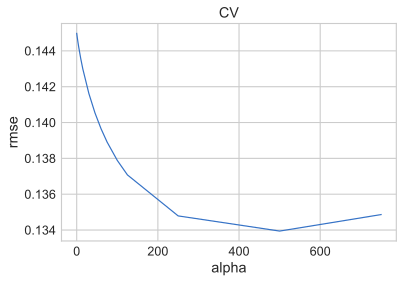

In [35]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "CV")
plt.xlabel("alpha")
plt.ylabel("rmse")
print('Минимальное значение RMSE: {:.4f}'.format(cv_ridge.min()))

In [36]:
#посмотрим как перформит лассо
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train_scaled_f, y_train)

In [37]:
#посмотрим на решающие признаки
crucial_fea = pd.Series(model_lasso.coef_, index = X_train_scaled_f.columns)    
print("Всего " + str(sum(crucial_fea != 0)) + " признаков важны а остальные " \
                                                            +  str(sum(crucial_fea == 0)) + " не имеют значения")

Всего 186 признаков важны а остальные 85 не имеют значения


In [38]:
#посмотрим на топ-15 и ласт-15
imp_fea = pd.concat([crucial_fea.sort_values().head(15),
                     crucial_fea.sort_values().tail(15)])

Text(0.5,1,'Важные признаки/не важные признаки')

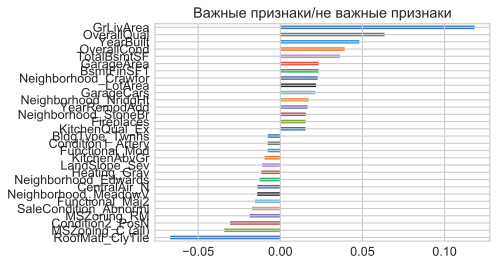

In [39]:
imp_fea.plot(kind = "barh")
plt.title("Важные признаки/не важные признаки")

### отлично размялись, теперь пора перейти к серьезным вещам

#### 2. Построить случайный лес, вывести важность признаков

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
features_name = X_train_scaled_f.columns

In [42]:
clf_rf = RandomForestRegressor()
#clf_rf = RandomForestRegressor(n_estimators=1000, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)

In [43]:
clf_rf.fit(X_train_scaled_f, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [44]:
#посмотрим на RMSE на train
rf_price_predictions = clf_rf.predict(X_train_scaled_f)
lin_mse = mean_squared_error(y_train, rf_price_predictions)
lin_rmse = np.sqrt(lin_mse)

print('RMSE на train: {:.4f}'.format(lin_rmse))

RMSE на train: 0.0619


`RMSE 0.065` (круто, вошли в топ-3 kaggl'a) 

Посмотрим на важность признаков RF

In [45]:
imp = pd.Series(clf_rf.feature_importances_)
imp.sort_values(ascending=False).head(20)

4      0.531384
16     0.116429
12     0.049471
27     0.039382
26     0.033462
9      0.024477
13     0.018151
6      0.017214
217    0.013612
5      0.010344
242    0.008995
3      0.008521
7      0.007726
41     0.007620
216    0.006315
11     0.005661
24     0.005089
2      0.004699
29     0.004549
25     0.004216
dtype: float64

In [46]:
rf_crucial_fea = pd.Series(clf_rf.feature_importances_, index = X_train_scaled_f.columns)    
print("Всего " + str(sum(rf_crucial_fea != 0)) + " признаков важны а остальные " \
                                                            +  str(sum(rf_crucial_fea == 0)) + " не имеют значения")

Всего 232 признаков важны а остальные 39 не имеют значения


In [47]:
#посмотрим на топ-15 и ласт-15
rf_imp_fea = pd.concat([rf_crucial_fea.sort_values().head(),
                     rf_crucial_fea.sort_values().tail(15)])

Посмотрим на важность признаков (визуализация важности признаков)

Text(0.5,1,'Важные признаки/не важные признаки')

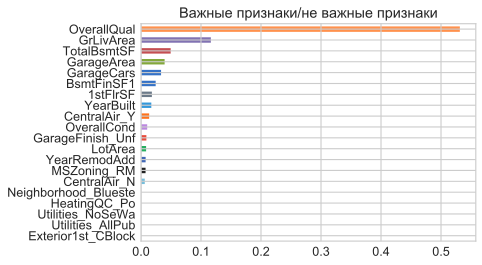

In [48]:
rf_imp_fea.plot(kind = "barh")
plt.title("Важные признаки/не важные признаки")

#### 3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

Будем использовать следующие модели:
- XGB
- LinearRegression
- RandomForestRegressor
- kNN

In [49]:
#для удобства сделаем новый набор данных для теста и трейна
X_train_st, X_test_st, y_train_st, y_test_st = \
                                    train_test_split(X_train_scaled_f, y_train, test_size = 0.3, random_state=5779)

In [50]:
X_train_st.shape

(1022, 271)

In [51]:
y_train_st.shape

(1022,)

In [52]:
import xgboost
from sklearn.neighbors import KNeighborsRegressor

- сделаем и зафитим модели

In [53]:
kNN = KNeighborsRegressor()
#xgb = xgboost.XGBRegressor()
lin_Reg = LinearRegression()
reg_RF = RandomForestRegressor()

In [54]:
kNN.fit(X_train_st, y_train_st)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [55]:
#xgb.fit(X_train_st, y_train_st)

In [56]:
lin_Reg.fit(X_train_st, y_train_st)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [57]:
reg_RF.fit(X_train_st, y_train_st)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

- возьмем функцию написанную преподавателем

In [58]:
def get_meta_features(clf, X_train_st, y_train_st, X_test_st, stack_cv):
    meta_train = np.zeros_like(y_train_st, dtype=float)
    meta_test = np.zeros_like(y_test_st, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train_st, y_train_st)):
        
        clf.fit(X_train_st.iloc[train_ind], y_train_st.iloc[train_ind])
        meta_train[test_ind] = clf.predict_proba(X_train_st.iloc[test_ind])[:, 1]
        meta_test += clf.predict_proba(X_test_st)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits

In [60]:
from sklearn.cross_validation import KFold, cross_val_score
k_fold = KFold(len(y_train_st), n_folds=10, shuffle=True, random_state=0)

print('Train...')
print('RF features...')
print(np.mean(cross_val_score(reg_RF, X_train_st, y_train_st, cv=k_fold, n_jobs=1)))
#print('XGB features...')
#print(np.mean(cross_val_score(xgb, X_train_st, y_train_st, cv=k_fold, n_jobs=1)))
print('kNN features...')
print(np.mean(cross_val_score(kNN, X_train_st, y_train_st, cv=k_fold, n_jobs=1)))
print('lin_Reg features...(тут что-то пошло не так)')
print(np.mean(cross_val_score(lin_Reg, X_train_st, y_train_st, cv=k_fold, n_jobs=1)))


Train...
RF features...
0.8554851223734323
kNN features...
0.7277202995723718
lin_Reg features...(тут что-то пошло не так)
-1.161200705109109e+25


In [61]:
k_fold = KFold(len(y_test_st), n_folds=10, shuffle=True, random_state=0)

print('Test...')
print('RF features...')
print(np.mean(cross_val_score(reg_RF, X_test_st, y_test_st, cv=k_fold, n_jobs=1)))
#print('XGB features...')
#print(np.mean(cross_val_score(xgb, X_test_st, y_test_st, cv=k_fold, n_jobs=1)))
print('kNN features...')
print(np.mean(cross_val_score(kNN, X_test_st, y_test_st, cv=k_fold, n_jobs=1)))
print('lin_Reg features...(тут что-то пошло не так)')
print(np.mean(cross_val_score(lin_Reg, X_test_st, y_test_st, cv=k_fold, n_jobs=1)))

Test...
RF features...
0.7861384742544442
kNN features...
0.6677179711331853
lin_Reg features...(тут что-то пошло не так)
-3.367096678106384e+25


### Дальше все сломалось........

In [62]:
from sklearn.model_selection import KFold

In [3]:
?KFold

In [6]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

In [12]:

kf = KFold(n_splits=)
t = kf.get_n_splits(X)

In [13]:
t

4

In [64]:
#from sklearn.model_selection import StratifiedKFold

stack_cv = KFold(n_splits=10)

meta_train = []
meta_test = []
col_names = []

#print('LR features...')
#meta_tr, meta_te = get_meta_features(lin_Reg, X_train_st, y_train_st, X_test_st, stack_cv)

#meta_train.append(meta_tr)
#meta_test.append(meta_te)
#col_names.append('xgb_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_RF, X_train_st, y_train_st, X_test_st, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')


print('XGB features...')
meta_tr, meta_te = get_meta_features(kNN, X_train_st, y_train_st, X_test_st, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('kNN_pred')

RF features...


NameError: name 'clf_RF' is not defined